# Just use weighted distance with UMAP, that's it.

In [79]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import datasets

from tqdm.auto import tqdm

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
dataset = datasets.load_from_disk("/Users/eric/code/visualizing-neural-scaling/files/the_pile_test_canonical_200k")

starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))
def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)

def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1

def print_context(idx):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")

In [3]:
curves = np.load("/Users/eric/code/visualizing-neural-scaling/files/pythia-410m-timeseries.npy")
steps = [0] + [2**i for i in range(10)] + list(range(1000, 144000, 1000))

# save mean curve with numpy
# np.save("/Users/eric/code/visualizing-neural-scaling/files/pythia-410m-mean-curve.npy", mean_curve)

# load mean curve with numpy
mean_curve = np.load("/Users/eric/code/visualizing-neural-scaling/files/pythia-410m-mean-curve.npy")

In [4]:
# DEFINE range of indices to visualize
indices = np.arange(0, curves.shape[0]-1, 1000)

In [70]:
# we want to weight the error such that earlier differences are more
# important than later differences (oh I should also be doing this 
# whole thing on the diffs!)

# since we're plotting on a log-x scale, we'll weight
# each plot by the density of points in that region
# on the plot. high density -> lower weight.
# we simply take log(steps) and then the distances
# between neighbors to be 1/density

weights = np.log10(steps[1:])
weights = np.diff(weights)
weights = np.insert(weights, 0, weights[0])
weights = np.append(weights, weights[-1])
# weights = 1 / weights
weights = weights / np.sum(weights)


In [71]:
# define custom metric
import numba

@numba.njit()
def dist(x, y):
    return np.average(np.power(x-y, 2), weights=weights)

In [93]:
umap.UMAP?

Init signature:
umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold

In [98]:
# perform UMAP with these coords
seed = 3
random.seed(seed)
np.random.seed(seed)
reducer = umap.UMAP(
    n_neighbors=50,
    transform_seed=seed, 
    min_dist=0.1,
    metric=dist)
embedding = reducer.fit_transform(curves[indices])

/Users/eric/code/miniconda3/envs/phase-changes/lib/python3.8/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


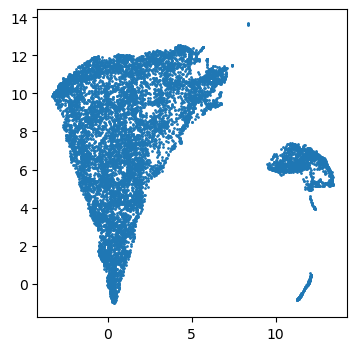

In [99]:
plt.figure(figsize=(4, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)

In [107]:
tokens = []
for i in tqdm(indices):
    doc, token_idx = get_context(i)
    doc_tokens = doc["split_by_token"]
    tokens.append(doc_tokens[max(0, token_idx-500):token_idx+1])

# torch.save((embedding, curves[indices], tokens), "../files/projection5.pt")
# save instead without torch with numpy and other python standard packages
np.save("../files/projection5/projection.npy", embedding)
np.save("../files/projection5/curves.npy", curves[indices])
# tokens is a list of lists of strings, save not with numpy
# but with pickle
import pickle
with open("../files/projection5/tokens.pkl", "wb") as f:
    pickle.dump(tokens, f)

  0%|          | 0/10659 [00:00<?, ?it/s]